# SYS 611: Dice Fighters Example (Monte Carlo Simulation)

Paul T. Grogan <pgrogan@stevens.edu>

This example shows how to conduct a Monte Carlo simulation with the Dice Fighters model previously developed.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `scipy.stats`, and `matplotlib.pyplot` libraries.

In [44]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy library and refer to it as `np`
import numpy as np

# import the scipy.stats library and refer to it as `stats`
import scipy.stats as stats

# import the matplotlib pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

## Model Definition

### Elementary State Variables

There are five elementary state variables defined below:
 * `round_number`: Current round number
 * `red_size`: Red force size 
 * `blue_size`: Blue force size
 * `red_chance_hit`: Red team probability of landing a 'hit' on a blue team
 * `blue_chance_hit`: Blue team probability of landing a 'hit' on a red team

All variables are defined with global scope and initialized to an initial value.

In [45]:
round_number = 0
red_size = 20
blue_size = 10
red_chance_hit = 1/6
blue_chance_hit = 3/6

### Derived State Variables

There is one derived state variable defined below:
 * `is_complete`: Determines if a game is complete.

In [46]:
def is_complete():
    """
    Check if the game is complete, meaning at least one team has no forces remaining.
    Return True if the game is complete, False otherwise.
    """
    return (red_size <= 0 or blue_size <= 0)

### Process Generators

There are two process generator functions defined below:
 * `generate_red_hits`: a process generator to determine how many hits the red team scores
 * `generate_blue_hits`: a process generator to determine how many hits the blue team scores

These functions use the built-in binomial process generator in numpy to generate the number of hits based on the number of forces remaining.

In [47]:
# define the generate_red_hits function
def generate_red_hits():
    """
    Randomly generate the number of red hits on the blue team.
    """
    # use a built-in numpy process generator:
    return np.random.binomial(red_size, red_chance_hit)

# define the generate_blue_hits function
def generate_blue_hits():
    """
    Randomly generate the number of blue hits on the red team.
    """
    # use a built-in numpy process generator:
    return np.random.binomial(blue_size, blue_chance_hit)

### State Transition Functions

There are three state transition functions defined below:
 * `red_suffer_losses`: decreases the red force size by the number of blue hits
 * `generate_red_hits`: decreases the blue force size by the number of red hits
 * `next_round`: advances to the next round

In [48]:
def red_suffer_losses(opponent_hits):
    """
    Decrease the red team size by the number of blue hits.
    """
    # (note: red_size must be declared as a global variable to update in this function!)
    global red_size
    # update the red_size based on the number of opponent hits
    red_size -= opponent_hits

def blue_suffer_losses(opponent_hits):
    """
    Decrease the blue team size by the number of red hits.
    """
    # (note: blue_size must be declared as a global variable to update in this function!)
    global blue_size
    # update the blue_size based on number of opponent hits
    blue_size -= opponent_hits

def next_round():
    """
    Advance to the next round.
    """
    # (note: round_number must be declared as a global variable to update in this function!)
    global round_number
    # advance the round_number
    round_number += 1

## Battle Generator

The following function runs a complete dice fighters match as a complex process generator and returns the name of the winner (`red`, `blue`, or `tie`).

In [49]:
def generate_battle():
    # declare global variables for any elementary state to be modified during execution
    global round_number, red_size, blue_size
    
    # reset the elementary state variables to initial values
    round_number = 0
    red_size = 20
    blue_size = 10

    # main execution loop: continue while the game is not complete
    while not is_complete():
        # generate the number of red hits
        red_hits = generate_red_hits()
        # generate the number of blue hits
        blue_hits = generate_blue_hits()
        # red team suffers losses of blue hits
        red_suffer_losses(blue_hits)
        # blue team suffers losses of red hits
        blue_suffer_losses(red_hits)
        # advance to the next round
        next_round()
        
    # after main loop exists, check who won (whichever team still has fighters!)
    if red_size > 0:
        return 'red'
    elif blue_size > 0:
        return 'blue'
    else:
        return 'tie'

print(generate_battle())

red


## Monte Carlo Simulation

This section sets up and performs a Monte Carlo simulation.

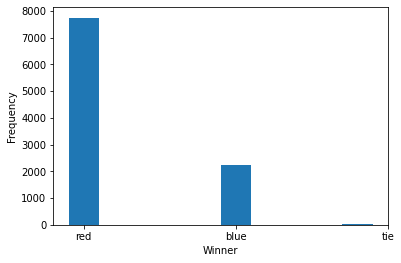

P(W=red) = 0.774 +/- 0.008 (95% CI)
P(W=tie) = 0.004 +/- 0.001 (95% CI)


In [50]:
# seed the random number generator for consistent results
np.random.seed(0)

# generate samples and store in a numpy array
samples = np.array([generate_battle() for i in range(10000)])

plt.figure()
plt.hist(samples, align='left')
plt.xlabel('Winner')
plt.ylabel('Frequency')
plt.show()

# compute the z factor for confidence intervals (1.95 for 95% confidence interval)
confidence_level = 0.05
z_crit = stats.norm.ppf(1-confidence_level/2)

# report the 95% confidence interval for red winning
print('P(W=red) = {:.3f} +/- {:.3f} (95% CI)'.format(
        np.average(samples=='red'),
        z_crit*stats.sem(samples=='red')
    ))

# just for fun, report the 95% confidence interval for tie games
print('P(W=tie) = {:.3f} +/- {:.3f} (95% CI)'.format(
        np.average(samples=='tie'),
        z_crit*stats.sem(samples=='tie')
    ))

## Running Statistics

Alternatively, one can visualize the running statistics throughout the Monte Carlo simulation, illustrating convergence to the expected value.

In [ ]:
# compute running statistics for mean and confidence interval
win_red_mean = np.array([
    np.average(samples[0:i]=='red') 
    for i in range(2,len(samples))
])
win_red_ci = z_crit*np.array([
    stats.sem(samples[0:i]=='red') 
    for i in range(2,len(samples))
])

# create a plot to show the mean estimate with 95% confidence interval bounds
plt.figure()
plt.plot(range(2,len(samples)), win_red_mean, 
         'b', label='Mean Estimate')
plt.plot(range(2,len(samples)), win_red_mean-win_red_ci, 
         'g', label='95% CI Lower Bound')
plt.plot(range(2,len(samples)), win_red_mean+win_red_ci, 
         'r', label='95% CI Upper Bound')
plt.xlabel('Sample')
plt.ylabel('Estimate of $P(W=red)$')
plt.legend(loc='best')
plt.show()